In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os import path

%matplotlib notebook

from brainpipe.feature import power, TF
from brainpipe.system import study
from brainpipe.visual import *
from brainpipe.statistics import *

In [8]:
import pandas as pd

st = study('Olfacto')
#file = 'SEMC_hit_R1R2R3_concat_allfilter1_bipo.npz'
file = 'SEMC_E1E2_concat_allfilter1.npz'
mat = np.load(path.join(st.path, 'database/TS_E_all_cond_by_block_trigs_th30_400art', file))
#mat = np.load(path.join(st.path, 'database/TS_R_Rec_cond_by_block_trigs_filter1_500art', file))

x, channel, sf = mat['x'], list(mat['channel']), mat['sf']
print (mat.files, mat['channel'][0], x.shape)


-> Olfacto loaded
['x', 'label', 'sf', 'xyz', 'channel'] ['b1'] (118, 2304, 41)


# Stat sur des features de power

La variable statmeth permet de choisir la méthode statistique pour comparer tes valeurs de puissance à la baseline. Tu peux choisir trois options :
- 'wilcoxon': rapide mais nécessite d'avantage d'essais
- 'kruskal': kruskal-wallis, rapide et marche sur un nombre d'essais plus petit
- 'permutation': plus robuste (parce que c'est data driven) mais plus lent. Cette méthode statistique fonctionne avec trois paramètres (je te conseil de demander à karim pour une explication appronfondie des permutations si tu n'es pas familière.):
    - n_perm : nombre de permutations qui permet de fixer le seuil stat minimum (donné par 1/n_perm)
    - tail : test one ou two-tail (-1 for testing A < B, 1 for A > B and 2 for A~=B)
    - metric : définit comment comparé les conditions A et B (genre (A-B)/moyenne(B))
    
    Je pense que tu peux laisser les paramètres tail et metric et jouer uniquement avec n_perm
   
## Calcul de la puissance + stat

In [5]:
elec = 0 # Exemple sur une seule électrode
#f = [2,4] #delta
#f = [5,7] #theta
#f = [8, 13] # alpha
#f = [13,30] #beta
f = [30,60] #low-gamma
statmeth = 'permutation'

# Calcul de la puissance :
powObj = power(sf, x.shape[1], f=f, norm=3, baseline=(0, 512), width=100, step=50)
print ('powObj size', x.shape[1], x[1])
xpow, pval = powObj.get(x[elec, ...], statmeth=None, n_perm = 1000, maxstat=0)
print (xpow.shape,) #pval.shape)

# Juste pour enlever les dimensions inutiles :
xpow, pval = np.squeeze(xpow), np.squeeze(pval)
print (xpow.shape, pval.shape)
print (pval)

# Correction de la p value
xpow_max = maxstat(xpow, axis=0) # to correct through time
print (xpow_max, xpow_max.shape)
pval_corr= perm_2pvalue(xpow, xpow_max, n_perm = 1000, threshold=None, tail=2)

#xpow = np.squeeze(powObj.get(x[np.newaxis, ...])[0])
#time = 1000 * powObj.xvec /sf
time = powObj.xvec
#print (time.shape)

# Disons que je viens de calculer les p-values de puissance avec des permutations. 
# La fonction power me renvoie une matrice de la taille pval.shape = (0: n_frequency, 1: n_points, 2: n_elec). Avec une correction par maximum statistique je peux faire une correction à travers :
# - Les fréquences : pval_corr = pval.max(0) et pval_corr.shape =  (0: n_points, 1: n_elec)
# - Le temps : pval_corr = pval.max(1) et pval_corr.shape =  (0: n_frequency, 1: n_elec)
# - Les électrodes : pval_corr = pval.max(2) et pval_corr.shape =  (0: n_frequency, 1: n_points)
# - Les fréquences et le temps: pval_corr = pval.max(0).max(0) et pval_corr.shape =  (0: n_elec)
# - Les fréquences et les électrodes: pval_corr = pval.max(0).max(1) et pval_corr.shape =  (0: n_points)
# - Le temps et les électrodes: pval_corr = pval.max(1).max(1) et pval_corr.shape =  (0: n_frequency)
# - Les fréquences, le temps et les électrodes: pval_corr = pval.max() et pval_corr est un simple nombre puisque c'est le maximum à travers toutes les dimensions



powObj size 3072 [[ -48.4375       17.87109375   38.57421875 ..., -122.265625     -2.63671875
    29.00390625]
 [ -36.23046875   24.21875      39.74609375 ..., -119.23828125
   -11.23046875   19.53125   ]
 [ -34.5703125    35.3515625    29.19921875 ..., -111.62109375
   -15.72265625   -1.46484375]
 ..., 
 [ -24.51171875   14.16015625    2.83203125 ...,   51.85546875  -23.2421875
   -30.95703125]
 [ -23.6328125    18.5546875    -5.56640625 ...,   41.40625     -15.72265625
   -34.1796875 ]
 [ -17.96875       6.73828125   -8.10546875 ...,   39.35546875   -9.5703125
   -31.15234375]]
(1, 1, 60, 41)
(60, 41) ()
None
[[ 1.12187994  1.10546786  1.44153571 ...,  0.65838043  0.77122249
   2.16690736]
 [ 1.12187994  1.10546786  1.44153571 ...,  0.65838043  0.77122249
   2.16690736]
 [ 1.12187994  1.10546786  1.44153571 ...,  0.65838043  0.77122249
   2.16690736]
 ..., 
 [ 1.12187994  1.10546786  1.44153571 ...,  0.65838043  0.77122249
   2.16690736]
 [ 1.12187994  1.10546786  1.44153571 ...,  0.

ValueError: perm must have a shape of (1000, 60, 41) instead of (60, 41, 1)

## Plot de la puissance + des valeurs significatives
- En bleu, la puissance dans la bande sélectionnée
- En rouge, les valeurs significatives à 5e-2
- En vert, à 1e-2

<IPython.core.display.Javascript object>


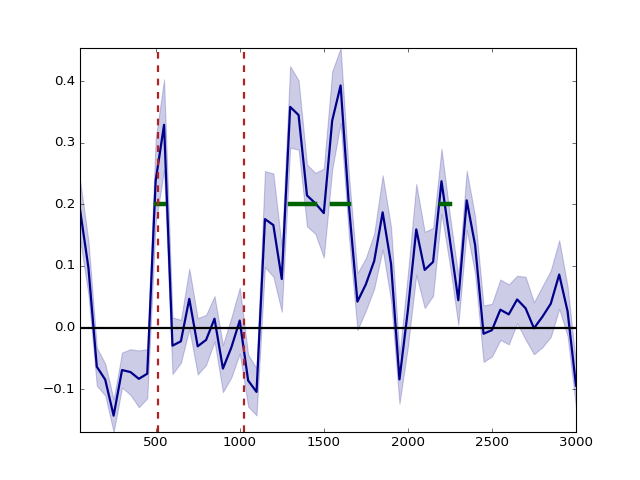

In [18]:
# Plot the TF maps :
plt.figure(0)
lines = (512, 1024)
BorderPlot(time, xpow, color='darkblue')
#BorderPlot(time, xpow, color='darkblue')
addPval(plt.gca(), pval, p=0.05, x=time, y=0.5, color='darkred', lw=3)
#addPval(plt.gca(), pval, p=0.05, x=time, y=0.5, color='darkred', lw=3)
addPval(plt.gca(), pval, p=0.01, x=time, y=0.2, color='darkgreen', lw=4)
addLines(plt.gca(), vLines=lines, vColor=['firebrick']*2, vWidth=[2]*2, hLines=[0], hColor=['#000000'], hWidth=[2])

# Cartes TF + stat

Finallement, la méthode est identique au module power, faut juste remplacer par TF...

## Calcul

In [6]:
tfObj = TF(sf, x.shape[1], f=(2, 120, 2, 1), norm=3, baseline=(0, 512), width=100, step=50)
xtf, pvaltf = tfObj.get(x[56, ...], statmeth='permutation', n_perm=1000, maxstat=False)
print(xtf.shape, pvaltf.shape)
print (pvaltf[0])
pval_corr = pvaltf.max(2) #to correct over the time dimension
pvaltf_corr = perm2pvalue
# Juste pour enlever les dimensions inutiles :
xtf, pval_corr = 100*np.squeeze(xtf), np.squeeze(pval_corr)
time = tfObj.xvec
print(xtf.shape, pval_corr.shape)
#pvaltf_corr = pvaltf.max(0)
#print (pvaltf_corr.shape)

(117, 1, 60) (117, 1, 60)
[[ 0.048  0.096  0.321  0.026  0.022  0.03   0.125  0.23   0.649  0.614
   0.181  0.102  0.059  0.005  0.019  0.057  0.054  0.366  0.236  0.021
   0.003  0.016  0.001  0.032  0.054  0.237  0.314  0.056  0.001  0.001
   0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001
   0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001
   0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.003  0.001  0.365]]
(117, 60) (117,)


## Plot

Perso, pour afficher mes parties significatives dans une carte TF, j'utilise deux méthodes :
- Le contour: affiche un contour là où tu as des valeurs significatives
- Le masque: les valeurs non significatives deviennent moins claires

### Plot avec contour significatif

In [42]:
# Plot everything that is inside the window parameter :
window = (513, 3072)
timebin = np.array(tfObj.xvec)
sl = slice(np.argmin(np.abs(timebin-window[0])), np.argmin(np.abs(timebin-window[1])))
        
p = tilerplot()
lines = [512,1024]
fig = plt.figure(1)
p.plot2D(fig, xtf[:,sl], cmap='viridis', vmin=-100, vmax=100, xvec=tfObj.xvec[sl], yvec=tfObj.yvec,
         cblabel='Relative power modulations (%)', resample=(0.1, 0.1),
         contour={'data':pvaltf_corr[:,sl], 'level':[0.01, 0.05], 'colors':['w', 'orange'], 'linewidths':[2, 1]});
# p.plot2D(fig, xtf, cmap='viridis', vmin=-200, vmax=200, xvec=tfObj.xvec, yvec=tfObj.yvec,
#          cblabel='Relative power modulations (%)', resample=(0.1, 0.1),
#          contour={'data':pvaltf, 'level':[0.01, 0.05], 'colors':['w', 'orange'], 'linewidths':[2, 1]});
addLines(plt.gca(), vLines=lines, vColor=[
            'firebrick']*2, vWidth=[2]*2)

IndexError: too many indices for array

### Plot avec un mask + contour

<IPython.core.display.Javascript object>


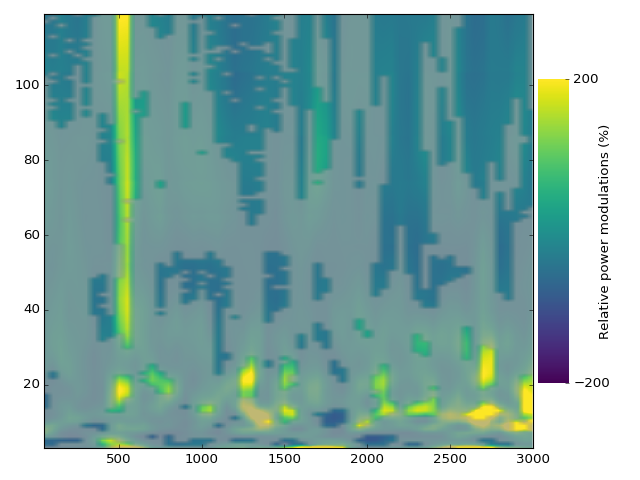

In [68]:
th = 0.01 # toute les valeurs au dessus de ce seuil stat seront moins opaques

mask = pvaltf.copy()
signi_idx = mask <= th
mask[signi_idx] = 1
mask[np.invert(signi_idx)] = 0.6 # control le niveau d'opacité des éléments non-significatifs


fig1 = plt.figure(2)
p.plot2D(fig1, xtf, cmap='viridis', vmin=-200, vmax=200, xvec=tfObj.xvec, yvec=tfObj.yvec,
         cblabel='Relative power modulations (%)', mask=mask, pltype='imshow', resample=(0.1, 0.1));

### Mask + contour

<IPython.core.display.Javascript object>


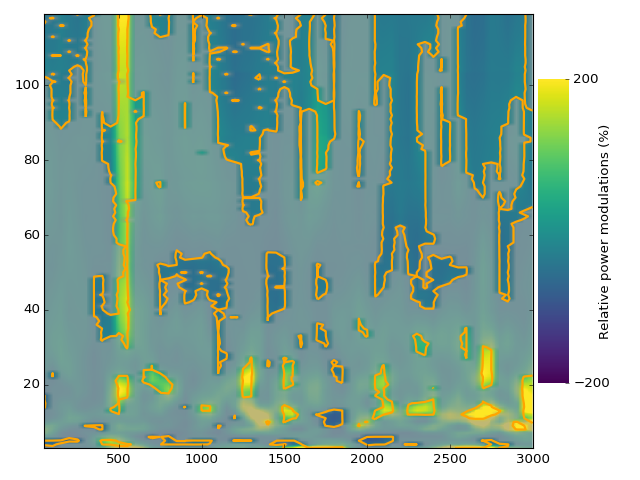

In [69]:
fig1 = plt.figure(3)
p.plot2D(fig1, xtf, cmap='viridis', vmin=-200, vmax=200, xvec=tfObj.xvec, yvec=tfObj.yvec,
         cblabel='Relative power modulations (%)', mask=mask, pltype='imshow', resample=(0.1, 0.1),
         contour={'data':pvaltf, 'level':[0.01], 'colors':['orange'], 'linewidths':2});